Train sequences: (2494, 50, 1), Train labels: (2494, 1)
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


78/78 - 7s - 93ms/step - loss: 0.0029 - val_loss: 0.0015
Epoch 2/30
78/78 - 4s - 46ms/step - loss: 5.8903e-04 - val_loss: 0.0013
Epoch 3/30
78/78 - 2s - 32ms/step - loss: 4.2191e-04 - val_loss: 0.0015
Epoch 4/30
78/78 - 3s - 33ms/step - loss: 3.3985e-04 - val_loss: 0.0020
Epoch 5/30
78/78 - 3s - 36ms/step - loss: 3.3784e-04 - val_loss: 0.0013
Epoch 6/30
78/78 - 3s - 36ms/step - loss: 3.2198e-04 - val_loss: 0.0011
Epoch 7/30
78/78 - 2s - 28ms/step - loss: 2.5927e-04 - val_loss: 9.6540e-04
Epoch 8/30
78/78 - 3s - 34ms/step - loss: 3.5292e-04 - val_loss: 9.5493e-04
Epoch 9/30
78/78 - 2s - 29ms/step - loss: 3.4175e-04 - val_loss: 9.4460e-04
Epoch 10/30
78/78 - 3s - 32ms/step - loss: 2.5046e-04 - val_loss: 0.0011
Epoch 11/30
78/78 - 3s - 39ms/step - loss: 2.1416e-04 - val_loss: 0.0011
Epoch 12/30
78/78 - 4s - 55ms/step - loss: 2.9640e-04 - val_loss: 0.0022
Epoch 13/30
78/78 - 3s - 33ms/step - loss: 2.2968e-04 - val_loss: 0.0011
Epoch 14/30
78/78 - 3s - 33ms/step - loss: 2.4294e-04 - val_los

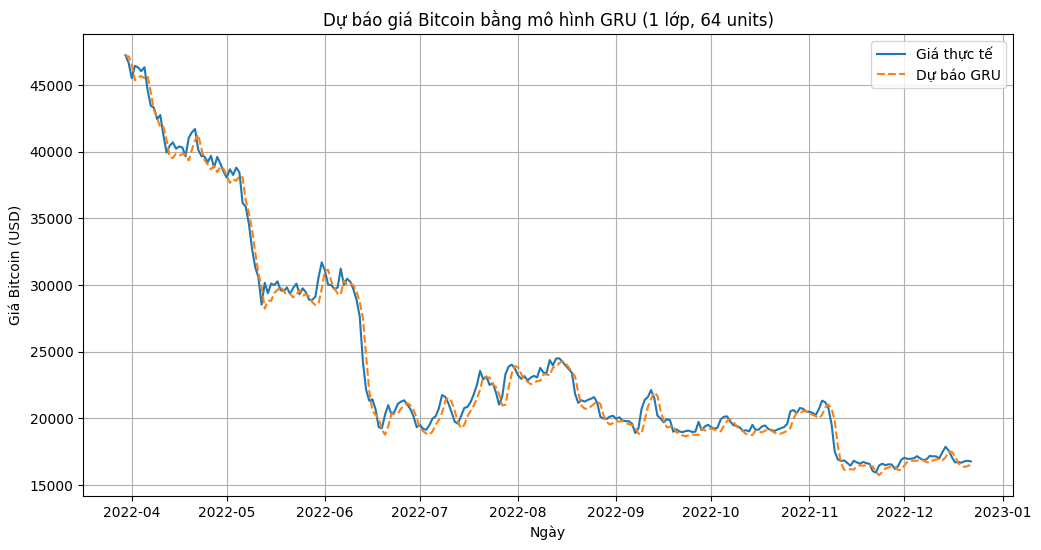

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout

# 1. Đọc và chuẩn bị dữ liệu
df = pd.read_csv('/content/BTC_Data_final.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df = df[['Date', 'priceUSD']]
df.set_index('Date', inplace=True)

# 2. Chia dữ liệu train/val/test (80/10/10)
n = len(df)
train_end = int(n * 0.8)
val_end = int(n * 0.9)

train = df.iloc[:train_end]
val = df.iloc[train_end:val_end]
test = df.iloc[val_end:]

# 3. Chuẩn hóa giá
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
val_scaled = scaler.transform(val)
test_scaled = scaler.transform(test)

# 4. Hàm tạo dữ liệu dạng sequence cho GRU
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 50  # Độ dài chuỗi đầu vào

X_train, y_train = create_sequences(train_scaled, seq_length)
X_val, y_val = create_sequences(val_scaled, seq_length)
X_test, y_test = create_sequences(test_scaled, seq_length)

print(f"Train sequences: {X_train.shape}, Train labels: {y_train.shape}")

# 5. Xây dựng mô hình GRU 1 lớp với 64 units
model = Sequential([
    GRU(64, return_sequences=False, input_shape=(seq_length, 1)),  # 1 lớp GRU, trả về output cuối cùng
    Dropout(0.2),
    Dense(1)  # Lớp đầu ra dự báo giá
])

# 6. Compile với Adam optimizer và learning rate 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse')

# 7. Huấn luyện mô hình với batch_size=32, epochs=30
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    verbose=2
)

# 8. Dự báo trên tập test
y_pred_scaled = model.predict(X_test)

# Chuyển dự báo và thực tế về thang giá gốc
y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y_test)

# 9. Đánh giá mô hình
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = np.mean(np.abs((y_true - y_pred) / y_true))

print(f"Test MAE: {mae:.2f}")
print(f"Test RMSE: {rmse:.2f}")
print(f"Test MAPE: {mape:.4f}")

# 10. Vẽ biểu đồ so sánh giá thực tế và dự báo
plt.figure(figsize=(12,6))
plt.plot(df.index[val_end + seq_length:], y_true, label='Giá thực tế')
plt.plot(df.index[val_end + seq_length:], y_pred, label='Dự báo GRU', linestyle='--')
plt.xlabel('Ngày')
plt.ylabel('Giá Bitcoin (USD)')
plt.title('Dự báo giá Bitcoin bằng mô hình GRU (1 lớp, 64 units)')
plt.legend()
plt.grid(True)
plt.show()


In [1]:
import tensorflow as tf
print(tf.__version__)


2.18.0


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout

# 1. Load and prepare data
df = pd.read_csv('/content/BTC_Data_final.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df = df[['Date', 'priceUSD']]
df.set_index('Date', inplace=True)

# 2. Split data 80/10/10
n = len(df)
train_end = int(n * 0.8)
val_end = int(n * 0.9)

train = df.iloc[:train_end]
val = df.iloc[train_end:val_end]
test = df.iloc[val_end:]

# 3. Scale price data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
val_scaled = scaler.transform(val)
test_scaled = scaler.transform(test)

# 4. Sequence creation function
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Hyperparameter options for first experiment
units_options = [32, 64]         # Number of GRU units
layers_options = [1, 2]          # Number of GRU layers
seq_length_options = [30, 50]    # Sequence length (days)
batch_size_options = [32, 64]    # Batch size
epochs_options = [30]            # Epochs
dropout_options = [0.2, 0.3]     # Dropout rate
learning_rate_options = [0.001]  # Learning rate

# To keep track of results
results = []

# Loop over hyperparameter combinations
import itertools
for units, layers, seq_length, batch_size, epochs, dropout, lr in itertools.product(
    units_options, layers_options, seq_length_options, batch_size_options, epochs_options, dropout_options, learning_rate_options):

    print(f"Testing config: units={units}, layers={layers}, seq_length={seq_length}, batch_size={batch_size}, epochs={epochs}, dropout={dropout}, lr={lr}")

    # Prepare sequences for train, val, test
    X_train, y_train = create_sequences(train_scaled, seq_length)
    X_val, y_val = create_sequences(val_scaled, seq_length)
    X_test, y_test = create_sequences(test_scaled, seq_length)

    # Build model
    model = Sequential()
    if layers == 1:
        model.add(GRU(units, input_shape=(seq_length, 1)))
        model.add(Dropout(dropout))
    else:
        model.add(GRU(units, return_sequences=True, input_shape=(seq_length, 1)))
        model.add(Dropout(dropout))
        model.add(GRU(units // 2))
        model.add(Dropout(dropout))
    model.add(Dense(1))

    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='mse')

    # Train model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        verbose=0  # Set to 1 if you want to see training progress
    )

    # Predict on test set
    y_pred_scaled = model.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred_scaled)
    y_true = scaler.inverse_transform(y_test)

    # Calculate metrics
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true))

    print(f"Test MAE: {mae:.2f}, RMSE: {rmse:.2f}, MAPE: {mape:.4f}")
    print("-" * 60)

    # Store results
    results.append({
        'units': units,
        'layers': layers,
        'seq_length': seq_length,
        'batch_size': batch_size,
        'epochs': epochs,
        'dropout': dropout,
        'learning_rate': lr,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape
    })

# Optional: convert results to DataFrame for easier analysis
results_df = pd.DataFrame(results)
print("\nSummary of all experiments:")
print(results_df.sort_values('MAE').reset_index(drop=True))


Testing config: units=32, layers=1, seq_length=30, batch_size=32, epochs=30, dropout=0.2, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Test MAE: 570.03, RMSE: 821.21, MAPE: 0.0226
------------------------------------------------------------
Testing config: units=32, layers=1, seq_length=30, batch_size=32, epochs=30, dropout=0.3, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Test MAE: 1084.11, RMSE: 1362.67, MAPE: 0.0432
------------------------------------------------------------
Testing config: units=32, layers=1, seq_length=30, batch_size=64, epochs=30, dropout=0.2, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  
Test MAE: 1462.15, RMSE: 1796.72, MAPE: 0.0566
------------------------------------------------------------
Testing config: units=32, layers=1, seq_length=30, batch_size=64, epochs=30, dropout=0.3, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step  
Test MAE: 731.99, RMSE: 1057.87, MAPE: 0.0296
------------------------------------------------------------
Testing config: units=32, layers=1, seq_length=50, batch_size=32, epochs=30, dropout=0.2, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
Test MAE: 580.55, RMSE: 842.80, MAPE: 0.0241
------------------------------------------------------------
Testing config: units=32, layers=1, seq_length=50, batch_size=32, epochs=30, dropout=0.3, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
Test MAE: 581.82, RMSE: 833.96, MAPE: 0.0243
------------------------------------------------------------
Testing config: units=32, layers=1, seq_length=50, batch_size=64, epochs=30, dropout=0.2, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Test MAE: 556.01, RMSE: 813.84, MAPE: 0.0232
------------------------------------------------------------
Testing config: units=32, layers=1, seq_length=50, batch_size=64, epochs=30, dropout=0.3, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
Test MAE: 904.44, RMSE: 1096.60, MAPE: 0.0380
------------------------------------------------------------
Testing config: units=32, layers=2, seq_length=30, batch_size=32, epochs=30, dropout=0.2, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Test MAE: 880.57, RMSE: 1220.98, MAPE: 0.0352
------------------------------------------------------------
Testing config: units=32, layers=2, seq_length=30, batch_size=32, epochs=30, dropout=0.3, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Test MAE: 806.53, RMSE: 1188.58, MAPE: 0.0315
------------------------------------------------------------
Testing config: units=32, layers=2, seq_length=30, batch_size=64, epochs=30, dropout=0.2, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Test MAE: 688.84, RMSE: 1029.43, MAPE: 0.0273
------------------------------------------------------------
Testing config: units=32, layers=2, seq_length=30, batch_size=64, epochs=30, dropout=0.3, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Test MAE: 800.03, RMSE: 1219.20, MAPE: 0.0315
------------------------------------------------------------
Testing config: units=32, layers=2, seq_length=50, batch_size=32, epochs=30, dropout=0.2, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
Test MAE: 1200.41, RMSE: 1575.92, MAPE: 0.0482
------------------------------------------------------------
Testing config: units=32, layers=2, seq_length=50, batch_size=32, epochs=30, dropout=0.3, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step
Test MAE: 1380.71, RMSE: 1915.05, MAPE: 0.0538
------------------------------------------------------------
Testing config: units=32, layers=2, seq_length=50, batch_size=64, epochs=30, dropout=0.2, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
Test MAE: 696.80, RMSE: 1066.46, MAPE: 0.0292
------------------------------------------------------------
Testing config: units=32, layers=2, seq_length=50, batch_size=64, epochs=30, dropout=0.3, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step
Test MAE: 938.07, RMSE: 1365.54, MAPE: 0.0388
------------------------------------------------------------
Testing config: units=64, layers=1, seq_length=30, batch_size=32, epochs=30, dropout=0.2, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  
Test MAE: 640.36, RMSE: 826.02, MAPE: 0.0259
------------------------------------------------------------
Testing config: units=64, layers=1, seq_length=30, batch_size=32, epochs=30, dropout=0.3, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step  
Test MAE: 576.75, RMSE: 827.34, MAPE: 0.0230
------------------------------------------------------------
Testing config: units=64, layers=1, seq_length=30, batch_size=64, epochs=30, dropout=0.2, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test MAE: 810.53, RMSE: 1024.17, MAPE: 0.0320
------------------------------------------------------------
Testing config: units=64, layers=1, seq_length=30, batch_size=64, epochs=30, dropout=0.3, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  
Test MAE: 1129.61, RMSE: 1424.01, MAPE: 0.0460
------------------------------------------------------------
Testing config: units=64, layers=1, seq_length=50, batch_size=32, epochs=30, dropout=0.2, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
Test MAE: 488.13, RMSE: 696.64, MAPE: 0.0202
------------------------------------------------------------
Testing config: units=64, layers=1, seq_length=50, batch_size=32, epochs=30, dropout=0.3, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Test MAE: 544.41, RMSE: 766.76, MAPE: 0.0225
------------------------------------------------------------
Testing config: units=64, layers=1, seq_length=50, batch_size=64, epochs=30, dropout=0.2, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Test MAE: 1008.79, RMSE: 1318.80, MAPE: 0.0406
------------------------------------------------------------
Testing config: units=64, layers=1, seq_length=50, batch_size=64, epochs=30, dropout=0.3, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
Test MAE: 661.35, RMSE: 965.49, MAPE: 0.0278
------------------------------------------------------------
Testing config: units=64, layers=2, seq_length=30, batch_size=32, epochs=30, dropout=0.2, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Test MAE: 966.41, RMSE: 1189.36, MAPE: 0.0377
------------------------------------------------------------
Testing config: units=64, layers=2, seq_length=30, batch_size=32, epochs=30, dropout=0.3, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Test MAE: 645.52, RMSE: 949.84, MAPE: 0.0257
------------------------------------------------------------
Testing config: units=64, layers=2, seq_length=30, batch_size=64, epochs=30, dropout=0.2, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Test MAE: 1093.48, RMSE: 1361.20, MAPE: 0.0416
------------------------------------------------------------
Testing config: units=64, layers=2, seq_length=30, batch_size=64, epochs=30, dropout=0.3, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Test MAE: 660.11, RMSE: 985.92, MAPE: 0.0255
------------------------------------------------------------
Testing config: units=64, layers=2, seq_length=50, batch_size=32, epochs=30, dropout=0.2, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
Test MAE: 1400.15, RMSE: 1689.16, MAPE: 0.0568
------------------------------------------------------------
Testing config: units=64, layers=2, seq_length=50, batch_size=32, epochs=30, dropout=0.3, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
Test MAE: 1303.19, RMSE: 1626.96, MAPE: 0.0530
------------------------------------------------------------
Testing config: units=64, layers=2, seq_length=50, batch_size=64, epochs=30, dropout=0.2, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step
Test MAE: 1482.58, RMSE: 1849.31, MAPE: 0.0597
------------------------------------------------------------
Testing config: units=64, layers=2, seq_length=50, batch_size=64, epochs=30, dropout=0.3, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step
Test MAE: 911.46, RMSE: 1292.37, MAPE: 0.0369
------------------------------------------------------------

Summary of all experiments:
    units  layers  seq_length  batch_size  epochs  dropout  learning_rate  \
0      64       1          50          32      30      0.2          0.001   
1      64       1          50          32      30      0.3          0.001   
2      32       1          50          64      30      0.2          0.001   
3      32       1          30          32      30      0.2          0.001   
4      64       1          30          32      30      0.3          0.001   
5      32       1          50          32      30      0.2          0.001   
6      32       1          50          32      30      0.3          0.001   
7      64       1          30          32      30      0.2          0.001   
8      64       2          30          32      30      0.3          0.001   
9      64       2          30          64      30      0

In [3]:
!jupyter nbconvert --to html GRU.ipynb


[NbConvertApp] WARNING | pattern 'GRU.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
    Execute